In [1]:
!pip install monai==0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 kB 3.8 MB/s eta 0:00:0000:0100:01m


In [2]:
import os
import sys
import time
import math
import copy
import torch
from torch import nn as nn
import numpy as np
from matplotlib import pyplot as plt
from easydict import EasyDict
from typing import List, Dict, Union, Sequence, Callable

from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Randomizable,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ToTensord,
)
from monai.utils import set_determinism

2024-05-30 17:19:13.476555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 17:19:13.476676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 17:19:13.631864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
cfg = EasyDict()
cfg.epoch = 15
cfg.learning_rate = 0.001
cfg.weight_decay = 0.00001

cfg.segnet = EasyDict()
cfg.segnet.img_shape = (96, 96, 96)
cfg.segnet.input_dim = 4  # number of input channels
cfg.segnet.output_dim = 3  # number of output channels
cfg.segnet.num_layers = 4  # number of layers in encoder/decoder
cfg.segnet.init_filters = 64  # number of filters in the first layer

In [4]:
root_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_dir = "/kaggle/working/"

In [5]:
set_determinism(seed=0)

In [6]:
import torch
import torch.nn as nn

class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DecoderBlock3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(DecoderBlock3D, self).__init__()
        self.conv1 = ConvBlock3D(in_channels, middle_channels)
        self.conv2 = ConvBlock3D(middle_channels, out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class SegNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegNet3D, self).__init__()
        # Encoder blocks (convolution + max pooling)
        self.encoder1 = ConvBlock3D(in_channels, 64)
        self.encoder2 = nn.Sequential(
            ConvBlock3D(64, 128),
            nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        )
        self.encoder3 = nn.Sequential(
            ConvBlock3D(128, 256),
            nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        )
        self.encoder4 = nn.Sequential(
            ConvBlock3D(256, 512),
            nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        )

        # Decoder blocks (upsampling + convolution)
        self.decoder1 = DecoderBlock3D(512, 512, 256)
        self.decoder2 = DecoderBlock3D(256, 256, 128)
        self.decoder3 = DecoderBlock3D(128, 128, 64)
        self.decoder4 = nn.Conv3d(64, out_channels, kernel_size=3, padding=1)

        # Unpooling layers
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def forward(self, x):
        # Forward pass through the encoder blocks
        x = self.encoder1(x)
        size0 = x.size()
        x, indices1 = self.encoder2(x)
        size1 = x.size()
        x, indices2 = self.encoder3(x)
        size2 = x.size()
        x, indices3 = self.encoder4(x)

        # Forward pass through the decoder blocks
        x = self.unpool1(x, indices3, output_size=size2)
        x = self.decoder1(x)
        x = self.unpool2(x, indices2, output_size=size1)
        x = self.decoder2(x)
        x = self.unpool3(x, indices1, output_size=size0)
        x = self.decoder3(x)
        x = self.decoder4(x)

        return x

In [8]:
def plot_data_distribution(num_train: int, num_val: int, num_test: int):
    """Plot number of data for train-set, val-set, and test-set after splitted"""

    # Create the bar chart
    bars = plt.bar(["Train", "Val", "Test"],
            [num_train, num_val, num_test], align='center', color=['green', 'red', 'blue'])

    # Add the data value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()


def load_datalist(
    root_dir: str
) -> List[Dict]:
    """
    Load image/label paths of dataset
    """
    
    datalist = []
    for data in os.listdir(root_dir):
        data_dir_path = os.path.join(root_dir, data)
        if os.path.isdir(data_dir_path):
            model_scans = ["flair", "t1", "t1ce", "t2"]
            image_paths = [os.path.join(data_dir_path, f"{data}_{model}.nii") for model in model_scans]
            label_path = os.path.join(data_dir_path, f"{data}_seg.nii")

            if (all(os.path.exists(path) for path in [*image_paths, label_path])):
                datalist.append({
                    "image": image_paths,
                    "label": label_path
                })

    return datalist


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(np.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 1, d[key] == 4), d[key] == 2
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = np.stack(result, axis=0).astype("float32")
        return d
    
    
class BratsDataset(Randomizable, CacheDataset):
    """
    Generate items for training, validation or test.
    """

    def __init__(
        self,
        root_dir: str,
        section: str,
        transform: Union[Sequence[Callable], Callable] = (),
        val_frac: float = 0.15,
        test_frac: float = 0.05,
        seed: int = 0,
        cache_num: int = sys.maxsize,
        cache_rate: float = 1.0,
        num_workers: int = 0,
    ) -> None:
        if not os.path.isdir(root_dir) or not os.path.exists(root_dir):
            raise RuntimeError(
                f"Cannot find dataset directory: {root_dir}."
            )

        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        self.indices: np.ndarray = np.array([])
        
        data = self._generate_data_list(root_dir)
        CacheDataset.__init__(
            self, data, transform, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers
        )

    def get_indices(self) -> np.ndarray:
        """
        Get the indices of datalist used in this dataset.
        """
        return self.indices

    def randomize(self, data: List[int]) -> None:
        self.R.shuffle(data)

    def _generate_data_list(self, root_dir: str) -> List[Dict]:
        datalist = load_datalist(root_dir)
        return self._split_datalist(datalist)

    def _split_datalist(self, datalist: List[Dict]) -> List[Dict]:
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        val_length = int(length * self.val_frac)
        test_length = int(length * self.test_frac)
        if self.section == "training":
            self.indices = indices[val_length+test_length:]
        elif self.section == "validation":
            self.indices = indices[test_length:val_length+test_length]
        else:
            self.indices = indices[:test_length]

        return [datalist[i] for i in self.indices]

In [9]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"], spatial_size=cfg.segnet.img_shape, mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

In [10]:
train_ds = BratsDataset(
    root_dir=root_dir,
    section="training",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = BratsDataset(
    root_dir=root_dir,
    section="validation",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

image shape: torch.Size([4, 96, 96, 96])


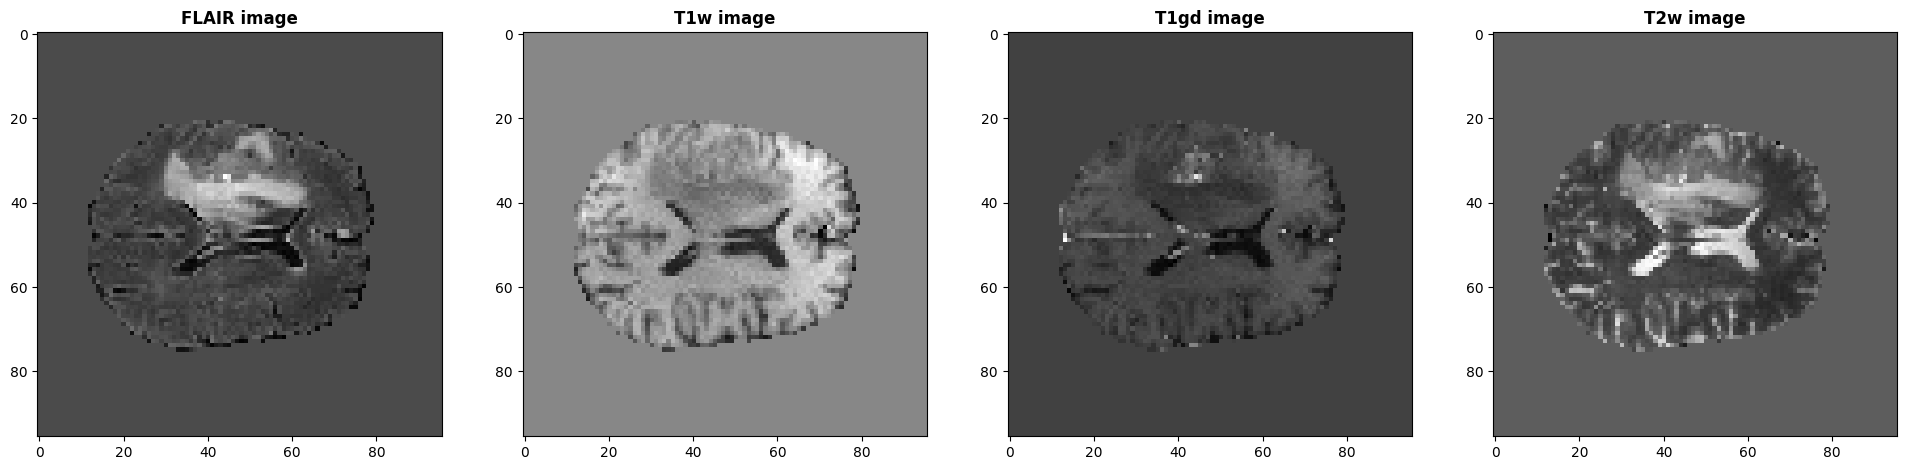

label shape: torch.Size([3, 96, 96, 96])


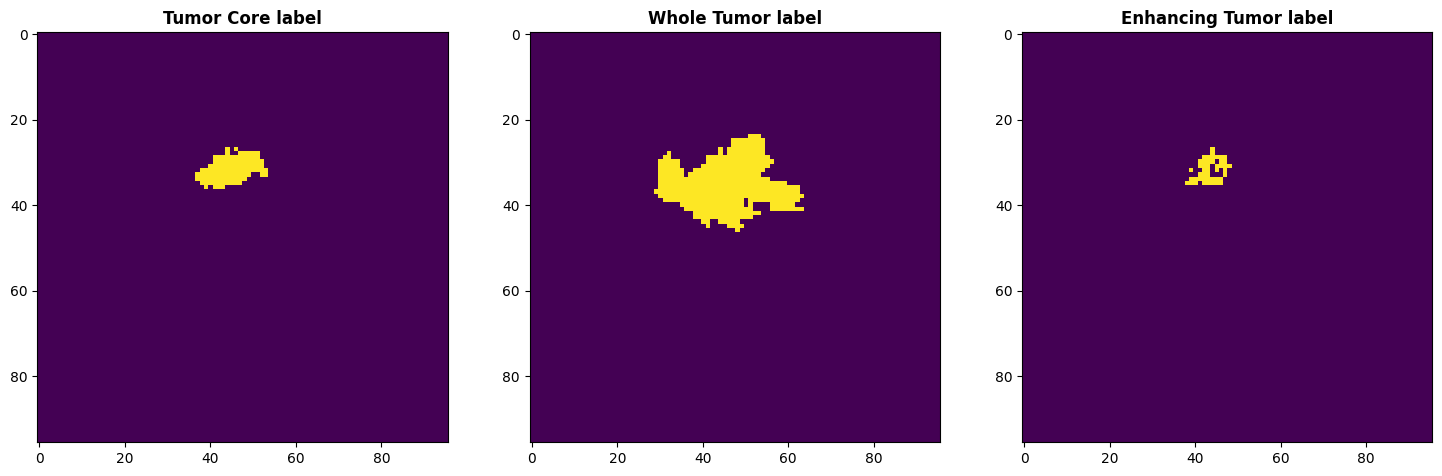

In [11]:
image_channels = ['FLAIR', 'T1w', 'T1gd', 'T2w']
label_channels = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor']

# pick one image from BratsDataset to visualize and check the 4 channels
val_data_example = val_ds[1]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(len(image_channels)):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{image_channels[i]} image", weight='bold')
    plt.imshow(val_data_example["image"][i, :, :, val_data_example['image'].shape[-1] // 2], cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(len(label_channels)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{label_channels[i]} label", weight='bold')
    plt.imshow(val_data_example["label"][i, :, :, val_data_example['image'].shape[-1] // 2])
plt.show()

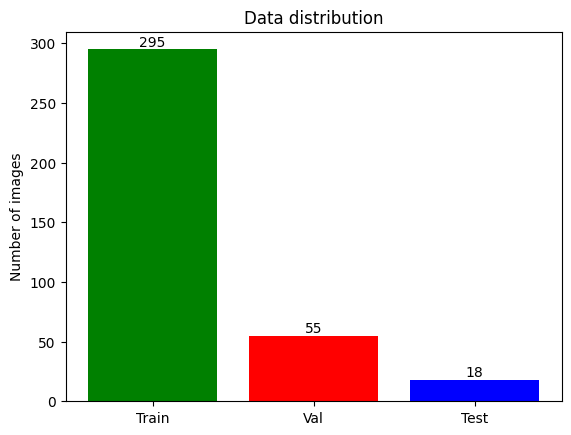

In [12]:
val_frac = val_ds.val_frac
test_frac = val_ds.test_frac

num_train = len(train_ds)
num_val = len(val_ds)
num_test = int(test_frac * num_val / val_frac)

plot_data_distribution(num_train, num_val, num_test)

In [13]:
val_interval = 1
VAL_AMP = True

# Check if CUDA (GPU support) is available
device = torch.device("cpu:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

model = SegNet3D(
    in_channels=cfg.segnet.input_dim,
    out_channels=cfg.segnet.output_dim
).to(device)

loss_function = DiceLoss(smooth_nr=0.1, smooth_dr=0.001, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=cfg.learning_rate, 
    momentum=0.9,          
    weight_decay=cfg.weight_decay
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epoch)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True, logit_thresh=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=cfg.segnet.img_shape,
            sw_batch_size=1,
            predictor=model,
        )
    

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


cuda:0


In [14]:
def precision(y_true, y_pred):
    true_positives = torch.sum((y_true * y_pred).round())
    predicted_positives = torch.sum(y_pred.round())
    return true_positives / (predicted_positives + 1e-7)

def sensitivity(y_true, y_pred):
    true_positives = torch.sum((y_true * y_pred).round())
    possible_positives = torch.sum(y_true.round())
    return true_positives / (possible_positives + 1e-7)

def specificity(y_true, y_pred):
    true_negatives = torch.sum(((1 - y_true) * (1 - y_pred)).round())
    possible_negatives = torch.sum((1 - y_true).round())
    return true_negatives / (possible_negatives + 1e-7)

def iou(y_true, y_pred):
    intersection = torch.sum((y_true * y_pred).round())
    union = torch.sum(y_true.round()) + torch.sum(y_pred.round()) - intersection
    return intersection / (union + 1e-7)

In [15]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(cfg.epoch):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{cfg.epoch}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        total_precision = 0
        total_sensitivity = 0
        total_specificity = 0
        total_iou = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_outputs_tensor = torch.stack(val_outputs)
                
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
                
                total_precision += precision(val_labels, val_outputs_tensor)
                total_sensitivity += sensitivity(val_labels, val_outputs_tensor)
                total_specificity += specificity(val_labels, val_outputs_tensor)
                total_iou += iou(val_labels, val_outputs_tensor)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            
            avg_precision = total_precision / len(val_loader)
            avg_sensitivity = total_sensitivity /  len(val_loader)
            avg_specificity = total_specificity /  len(val_loader)
            avg_iou = total_iou /  len(val_loader)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nprecision: {avg_precision:.4f} sensitivity: {avg_sensitivity:.4f} specificity: {avg_specificity:.4f} iou: {avg_iou:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
        torch.cuda.empty_cache()  # Clear cache after validation    
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/15
1/295, train_loss: 0.9857, step time: 12.6800
2/295, train_loss: 0.9860, step time: 0.4633
3/295, train_loss: 0.9879, step time: 0.4468
4/295, train_loss: 0.9825, step time: 0.4422
5/295, train_loss: 0.9573, step time: 0.4595
6/295, train_loss: 0.9750, step time: 0.4525
7/295, train_loss: 0.9962, step time: 0.4416
8/295, train_loss: 0.9583, step time: 0.4428
9/295, train_loss: 0.9750, step time: 0.4492
10/295, train_loss: 0.9509, step time: 0.4430
11/295, train_loss: 0.9946, step time: 0.4510
12/295, train_loss: 0.9911, step time: 0.4380
13/295, train_loss: 0.9702, step time: 0.4451
14/295, train_loss: 0.9646, step time: 0.4430
15/295, train_loss: 0.9739, step time: 0.4448
16/295, train_loss: 0.9484, step time: 0.4563
17/295, train_loss: 0.9974, step time: 0.4581
18/295, train_loss: 0.9796, step time: 0.4459
19/295, train_loss: 0.9940, step time: 0.4365
20/295, train_loss: 0.9963, step time: 0.4405
21/295, train_loss: 0.9763, step time: 0.4470
22/295, train_loss: 

In [16]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7620 at epoch: 10, total time: 3522.8129732608795.


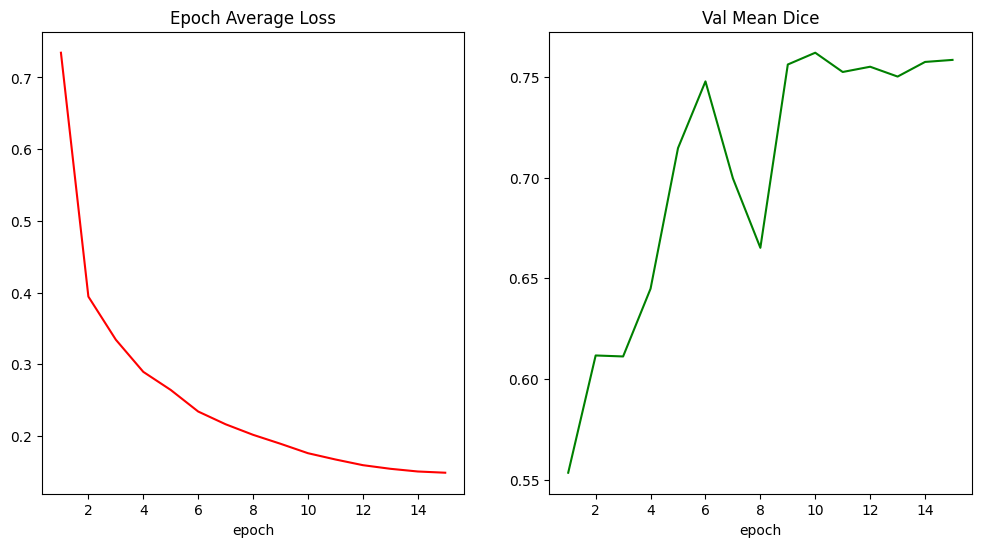

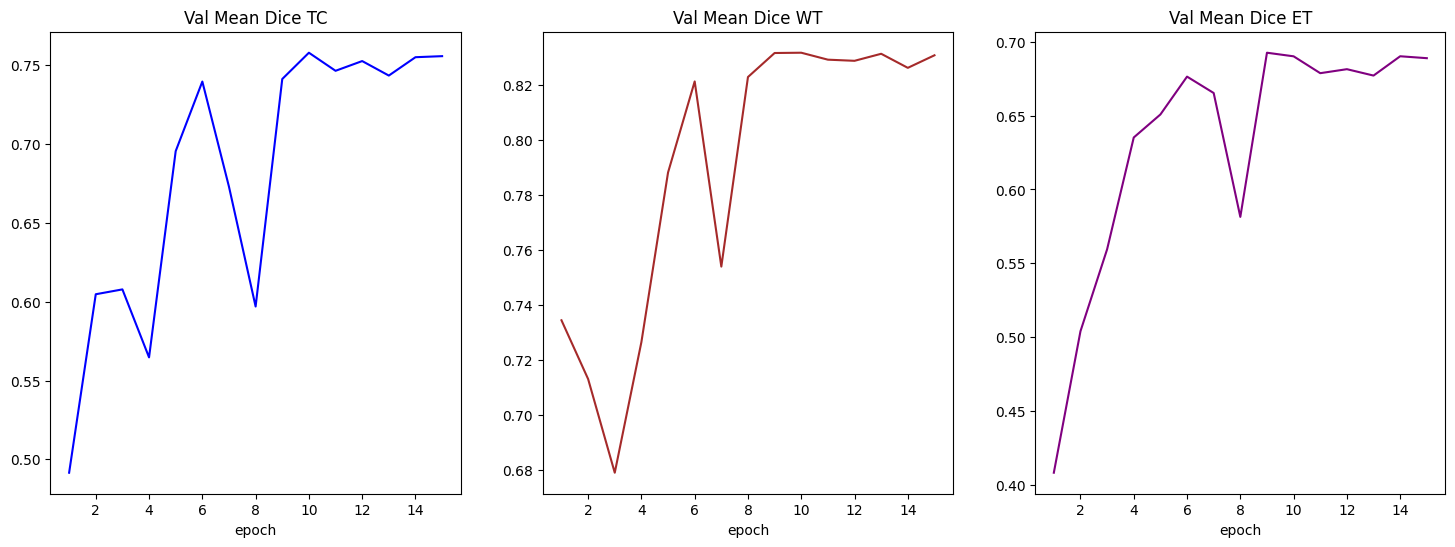

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

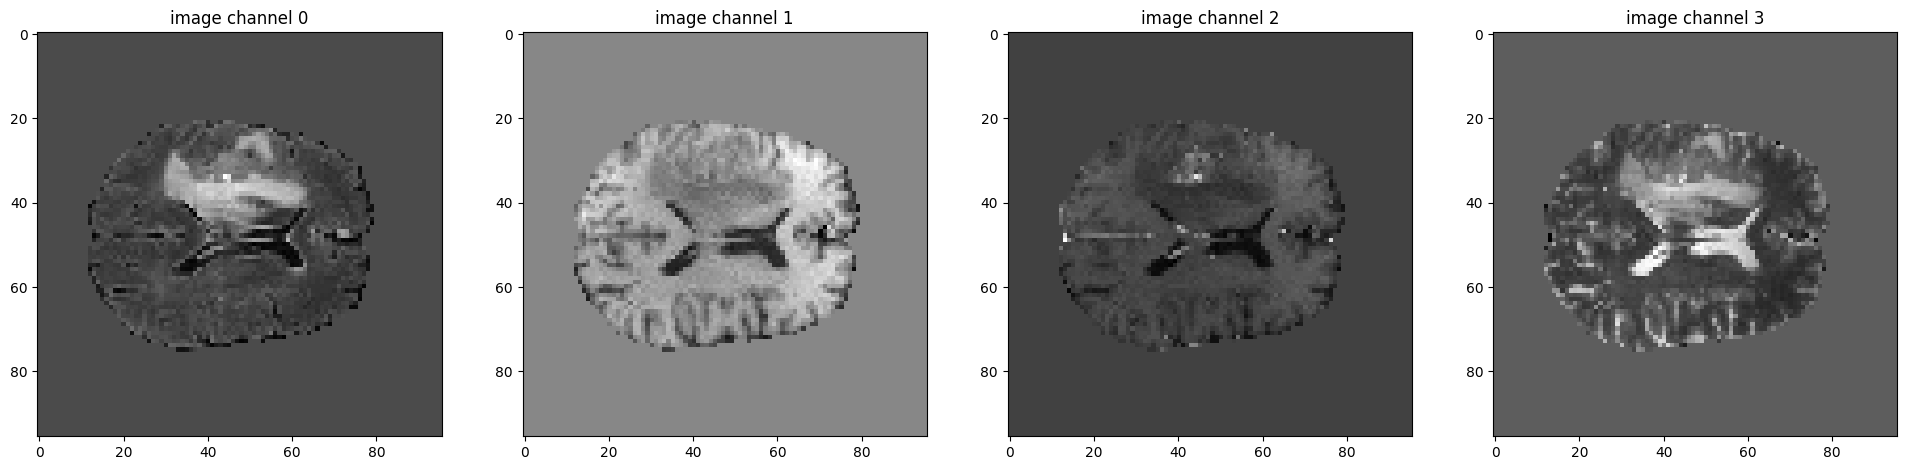

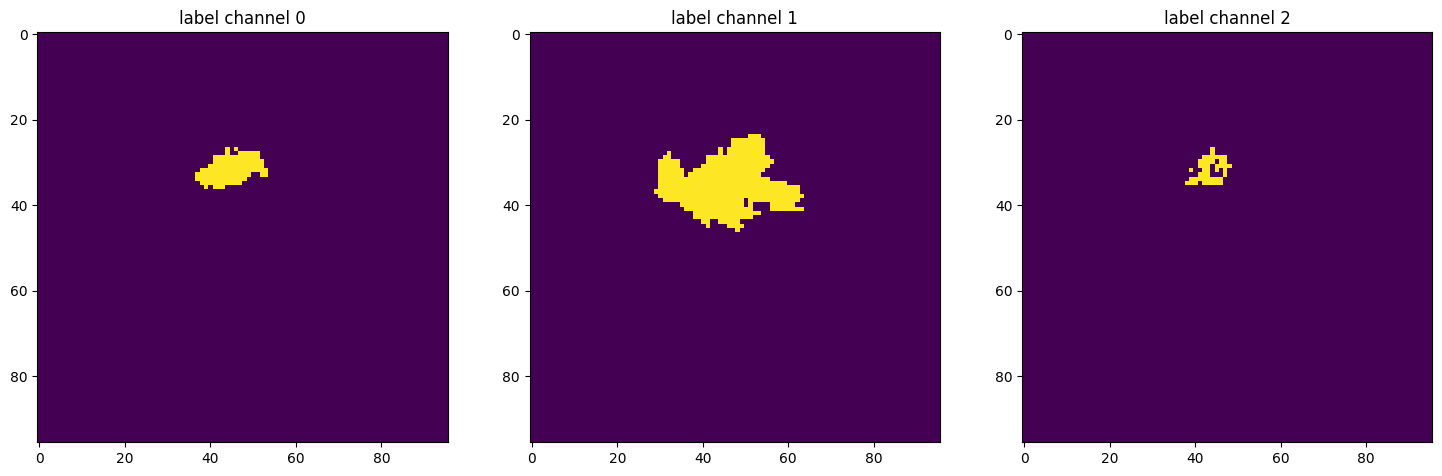

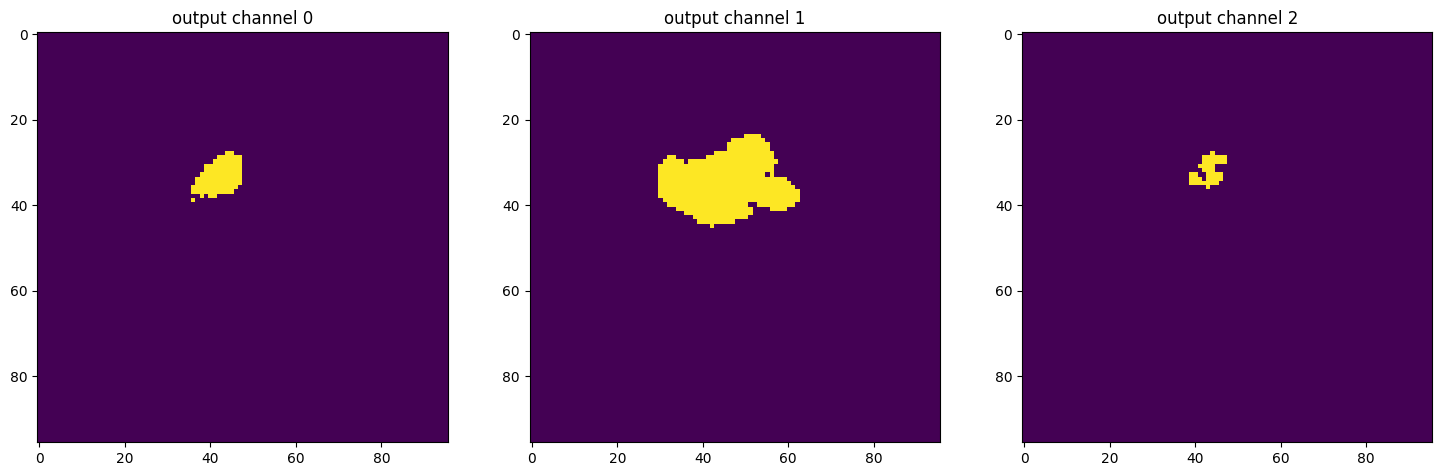

In [18]:
model.load_state_dict(torch.load(os.path.join(output_dir, "best_metric_model.pth")))
model.eval()
                      
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_data = val_ds[1]
    val_input = val_data["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_data["image"][i, :, :, val_input.shape[-1] // 2].detach().cpu(), cmap="gray")
    plt.show()
    
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_data["label"][i, :, :, val_input.shape[-1] // 2].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, val_input.shape[-1] // 2].detach().cpu())
    plt.show()

In [19]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear", "nearest"]
        ),
        Resized(keys=["image", "label"], spatial_size=cfg.segnet.img_shape, mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

test_ds = BratsDataset(
    root_dir=root_dir,
    section="test",
    transform=transform,
    cache_num=0
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

In [20]:
model.load_state_dict(torch.load(os.path.join(output_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        test_outputs = inference(test_inputs)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric(y_pred=test_outputs, y=test_labels)
        dice_metric_batch(y_pred=test_outputs, y=test_labels)

    metric = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on test image: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on test image:  0.7575320601463318
metric_tc: 0.7528
metric_wt: 0.8416
metric_et: 0.6835
